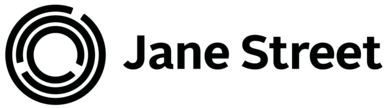

# Jane Street Market Prediction: A simple EDA

> "*Machine learning (ML) at Jane Street begins, unsurprisingly, with data. We collect and store around 2.3TB of market data every day. Hidden in those petabytes of data are the relationships and statistical regularities which inform the models inside our strategies. But it’s not just awesome models. ML work in a production environment like Jane Street’s involves many interconnected pieces.*" -- [Jane Street Tech Blog "*Real world machine learning*"](https://blog.janestreet.com/real-world-machine-learning-part-1/).

This notebook is a simple exploratory data analysis (EDA) of the files provided for the kaggle [Jane Street Market Prediction](https://www.kaggle.com/c/jane-street-market-prediction) competition. Here we shall...

> "**Explore the data:** *It’s hard to know what techniques to throw at a problem before we understand what the data looks like, and indeed figure out what data to use. Spending the time to visualize and understand the structure of the problem helps pick the right modeling tools for the job. Plus, pretty plots are catnip to traders and researchers!*"

## <center style="background-color:Gainsboro; width:40%;">Contents</center>
* [The train.csv file is big](#train_csv)
* [resp](#resp)
* [weight](#weight)
* [Cumulative return](#return)
* [Time](#time)
* [The features](#features)
* [The `features.csv` file](#features_file)
* [Action](#action)
* [The first day ("day 0")](#day_0)
* [Are there any missing values?](#missing_values)
* [Is there any missing data: Days 2 and 294](#missing_data)
* [DABL plots (targets: action and resp)](#DABL)
* [Permutation Importance using the Random Forest](#permutation)
* [Is there any correlation between day 100 and day 200?](#Pearson)
* [The test data](#test_data)
* [Evaluation](#evaluation)

In [ ]:
# numpy
import numpy as np

# pandas stuff
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# plotting stuff
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)
#plt.rcParams.update({'font.size': 12})


# install dabl
!pip install dabl > /dev/null
import dabl
# install datatable
!pip install datatable > /dev/null
import datatable as dt

# misc
import missingno as msno

# system
import warnings
warnings.filterwarnings('ignore')
# for the image import
import os
from IPython.display import Image
# garbage collector to keep RAM in check
import gc  

<a class="anchor" id="train_csv"></a>
## <center style="background-color:Gainsboro; width:40%;">The train.csv file is big</center>

The train.csv is large: 5.77G. Let us see just how many rows it has:

In [ ]:
!wc -l ../input/jane-street-market-prediction/train.csv

We can see that it has a total of 2,390,492 rows. I recommend reading this magnificent [Tutorial on reading large datasets](https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets) by [Vopani](https://www.kaggle.com/rohanrao).

I have used pandas to load in the `train.csv` and it took almost 2 minutes. To speed things up here I shall use [datatable](https://datatable.readthedocs.io/en/latest/):

In [ ]:
%%time

train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')

and then [convert to a pandas dataframe](https://datatable.readthedocs.io/en/latest/api/frame/to_pandas.html)

In [ ]:
%%time

train_data = train_data_datatable.to_pandas()

We now have loaded `train.csv` in less than 17 seconds.

<a class="anchor" id="return"></a>
## <center style="background-color:Gainsboro; width:40%;">resp</center>

There are a total of 500 days of data in `train.csv` (*i.e.* two years of trading data). Let us take a look at the cumulative values of `resp` over time

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("Cumulative resp", fontsize=18);
balance.plot(lw=3);
del balance
gc.collect();

as well as four [time horizons](https://www.investopedia.com/terms/t/timehorizon.asp)
> "*The longer the Time Horizon, the more aggressive, or riskier portfolio, an investor can build. The shorter the Time Horizon, the more conservative, or less risky, the investor may want to adopt.*"

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
resp_1= pd.Series(train_data['resp_1']).cumsum()
resp_2= pd.Series(train_data['resp_2']).cumsum()
resp_3= pd.Series(train_data['resp_3']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect();

We can see that `resp` (in blue) most closely follows time horizon 4 (`resp_4` is the uppermost curve, in purple). 

In the notebook ["*Jane Street: time horizons and volatilities*"](https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities) written by [pcarta](pcarta), if I understand correctly, by using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) it is calculated that if the time horizon $(T_j$) for `resp_1` (*i.e.* $T_1$) is 1, then 
* $T_j($ `resp_2` $) ~\approx 1.4 ~T_1$
* $T_j($ `resp_3` $) ~\approx 3.9 ~T_1$ 
* $T_j($ `resp_4` $) ~\approx 11.1 ~T_1$

where $T_1$ could correspond to 5 trading days.

Let us now plot a histogram of all of the `resp` values (here only shown for values between -0.05 and 0.05)

In [ ]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['resp'], 
             bins=3000, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.show();
gc.collect();

This distribution has very long tails

In [ ]:
min_resp = train_data['resp'].min()
print('The minimum value for resp is: %.5f' % min_resp)
max_resp = train_data['resp'].max()
print('The maximum value for resp is:  %.5f' % max_resp)

Let us also calculate the [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis) of this distribution:

In [ ]:
print("Skew of resp is:      %.2f" %train_data['resp'].skew() )
print("Kurtosis of resp is: %.2f"  %train_data['resp'].kurtosis() )

Finally, let us fit a [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) to this data

In [ ]:
from scipy.optimize import curve_fit
# the values
x = list(range(len(values)))
x = [((i)-1500)/30000 for i in x]
y = values

def Lorentzian(x, x0, gamma, A):
    return A * gamma**2/(gamma**2+( x - x0 )**2)

# seed guess
initial_guess=(0, 0.001, 3000)

# the fit
parameters,covariance=curve_fit(Lorentzian,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# and plot
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['resp'], 
             bins=3000, 
             kde_kws={"clip":(-0.05,0.05)}, 
             hist_kws={"range":(-0.05,0.05)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
#norm = plt.Normalize(values.min(), values.max())
#colors = plt.cm.jet(norm(values))
#for rec, col in zip(ax.patches, colors):
#    rec.set_color(col)
plt.xlabel("Histogram of the resp values", size=14)
plt.plot(x,Lorentzian(x,*parameters),'--',color='black',lw=3)
plt.show();
del values
gc.collect();

Note that a Cauchy distribution can be generated from the ratio of two independent normally distributed random variables with mean zero. The paper by [David E. Harris "*The Distribution of Returns*"](https://www.scirp.org/pdf/JMF_2017083015172459.pdf) goes into detail regarding the use of a Cauchy distribution to model returns.

<a class="anchor" id="weight"></a>
## <center style="background-color:Gainsboro; width:40%;">weight</center>

> *Each trade has an associated `weight` and `resp`, which together represents a return on the trade.
Trades with `weight = 0` were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.*

In [ ]:
percent_zeros = (100/train_data.shape[0])*((train_data.weight.values == 0).sum())
print('Percentage of zero weights is: %i' % percent_zeros +"%")

Let us see if there are any negative weights. A negative weight would be meaningless, but you never know...

In [ ]:
min_weight = train_data['weight'].min()
print('The minimum weight is: %.2f' % min_weight)

An now to find the maximum weight used

In [ ]:
max_weight = train_data['weight'].max()
print('The maximum weight was: %.2f' % max_weight)

which occured on day 446

In [ ]:
train_data[train_data['weight']==train_data['weight'].max()]

Let us take a look at a histogram of the non-zero weights

In [ ]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['weight'], 
             bins=1400, 
             kde_kws={"clip":(0.001,1.4)}, 
             hist_kws={"range":(0.001,1.4)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of non-zero weights", size=14)
plt.show();
del values
gc.collect();

There appear to be two peaks, one situated at `weight` $\approx$ 0.17, and a lower, broader peak at `weight` $\approx$ 0.34. Could this be indicative of two underlying distributions that we see here, superimposed on each other? Maybe one distribution of weights correspond to selling, and the other to buying?

We can plot the logarithm of the weights (*Credit*: ["*Target Engineering; CV; ⚡ Multi-Target*"](https://www.kaggle.com/marketneutral/target-engineering-cv-multi-target) by [marketneutral](https://www.kaggle.com/marketneutral))

In [ ]:
train_data_nonZero = train_data.query('weight > 0').reset_index(drop = True)
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(train_data_nonZero['weight']), 
             bins=1000, 
             kde_kws={"clip":(-4,5)}, 
             hist_kws={"range":(-4,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
plt.show();
gc.collect();

and we can now try to fit a pair of Gaussian functions to this distribution

In [ ]:
from scipy.optimize import curve_fit
# the values
x = list(range(len(values)))
x = [(i/110)-4 for i in x]
y = values

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

def bimodal(x,mu_1,sigma_1,A_1,mu_2,sigma_2,A_2):
    return Gaussian(x,mu_1,sigma_1,A_1) + Gaussian(x,mu_2,sigma_2,A_2)

# seed guess
initial_guess=(1, 1 , 1,    1, 1, 1)

# the fit
parameters,covariance=curve_fit(bimodal,x,y,initial_guess)
sigma=np.sqrt(np.diag(covariance))

# the plot
plt.figure(figsize = (10,4))
ax = sns.distplot(np.log(train_data_nonZero['weight']), 
             bins=1000, 
             kde_kws={"clip":(-4,5)}, 
             hist_kws={"range":(-4,5)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the logarithm of the non-zero weights", size=14)
# plot gaussian #1
plt.plot(x,Gaussian(x,parameters[0],parameters[1],parameters[2]),':',color='black',lw=2,label='Gaussian #1', alpha=0.8)
# plot gaussian #2
plt.plot(x,Gaussian(x,parameters[3],parameters[4],parameters[5]),'--',color='black',lw=2,label='Gaussian #2', alpha=0.8)
# plot the two gaussians together
plt.plot(x,bimodal(x,*parameters),color='black',lw=2, alpha=0.7)
plt.legend(loc="upper left");
plt.show();
del values
gc.collect();

with limited success; the narrower left hand peak seems to be some other distribution. (Just in case, the $\mu$ of the small Gaussian is located at -1.32, and the large Gaussian at 0.4).
<a class="anchor" id="return"></a>
## <center style="background-color:Gainsboro; width:40%;">Cumulative return</center>

Let us take a look at the cumulative daily return over time, which is given by `weight` multiplied by the value of `resp`

In [ ]:
train_data['weight_resp']   = train_data['weight']*train_data['resp']
train_data['weight_resp_1'] = train_data['weight']*train_data['resp_1']
train_data['weight_resp_2'] = train_data['weight']*train_data['resp_2']
train_data['weight_resp_3'] = train_data['weight']*train_data['resp_3']
train_data['weight_resp_4'] = train_data['weight']*train_data['resp_4']

fig, ax = plt.subplots(figsize=(15, 5))
resp    = pd.Series(1+(train_data.groupby('date')['weight_resp'].mean())).cumprod()
resp_1  = pd.Series(1+(train_data.groupby('date')['weight_resp_1'].mean())).cumprod()
resp_2  = pd.Series(1+(train_data.groupby('date')['weight_resp_2'].mean())).cumprod()
resp_3  = pd.Series(1+(train_data.groupby('date')['weight_resp_3'].mean())).cumprod()
resp_4  = pd.Series(1+(train_data.groupby('date')['weight_resp_4'].mean())).cumprod()
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Cumulative daily return for resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp.plot(lw=3, label='resp x weight')
resp_1.plot(lw=3, label='resp_1 x weight')
resp_2.plot(lw=3, label='resp_2 x weight')
resp_3.plot(lw=3, label='resp_3 x weight')
resp_4.plot(lw=3, label='resp_4 x weight')
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
plt.legend(loc="lower left");

We can see that the shortest time horizons, `resp_1`, `resp_2` and `resp_3`, representing a more conservative strategy, result in the lowest return.

We shall now plot a histogram of the `weight` multiplied by the value of `resp` (after removing the 0 weights)

In [ ]:
train_data_no_0 = train_data.query('weight > 0').reset_index(drop = True)
train_data_no_0['wAbsResp'] = train_data_no_0['weight'] * (train_data_no_0['resp'])
#plot
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data_no_0['wAbsResp'], 
             bins=1500, 
             kde_kws={"clip":(-0.02,0.02)}, 
             hist_kws={"range":(-0.02,0.02)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of the weights * resp", size=14)
plt.show();

<a class="anchor" id="time"></a>
## <center style="background-color:Gainsboro; width:40%;">Time</center>
Let us plot the number of `ts_id` per day. Note: I have taken to drawing a vertical dashed line in my plots because I started to wonder [did Jane Street modify their trading model around day 85?](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201930) Thanks to comments on that forum the general consenus seems to be that a change in the market took place around that time (perhaps a mean reverting market changing to a momentum market, or *vice versa*).

In [ ]:
trades_per_day = train_data.groupby(['date'])['ts_id'].count()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of ts_id for each day", fontsize=18)
# day 85 marker
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
plt.show()

If we assume a [trading day](https://en.wikipedia.org/wiki/Trading_day) is 6½ hours long (*i.e.* 23400 seconds) then

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(23400/trades_per_day)
ax.set_xlabel ("Day", fontsize=18)
ax.set_ylabel ("Av. time between trades (s)", fontsize=18)
ax.set_title ("Average time between trades for each day", fontsize=18)
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=1)
ax.axvspan(0, 85 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
ax.set_ylim(ymin=0)
ax.set_ylim(ymax=12)
plt.show()

Here is a histogram of the number of trades per day (it has been [suggested](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201930#1125847) that the number of trades per day is an indication of the [volatility](https://www.investopedia.com/terms/v/volatility.asp) that day)

In [ ]:
plt.figure(figsize = (12,4))
# the minimum has been set to 1000 so as not to draw the partial days like day 2 and day 294
# the maximum number of trades per day is 18884
# I have used 125 bins for the 500 days
ax = sns.distplot(trades_per_day, 
             bins=125, 
             kde_kws={"clip":(1000,20000)}, 
             hist_kws={"range":(1000,20000)},
             color='darkcyan', 
             kde=True);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Number of trades per day", size=14)
plt.show();

If that is the case, then 'volitile' days, say with more than 9k trades (*i.e.* `ts_id`) per day, are the following 

In [ ]:
volitile_days = pd.DataFrame(trades_per_day[trades_per_day > 9000])
volitile_days.T

It is interesting to note that almost all of the days having a large volume of trades are before and up to day 85.

Also related to time is `feature_64` which seems to be some sort of daily clock as we shall see below.

<a class="anchor" id="features"></a>
## <center style="background-color:Gainsboro; width:40%;">The features</center>

> "*This dataset contains an anonymized set of features, `feature_{0...129}`, representing real stock market data.*"

### feature_0
First of all, `feature_0` seems to be a little unusual, as it is composed solely of the integers `+1` or `-1`:

In [ ]:
train_data['feature_0'].value_counts()

Also, `feature_0` is the *only* feature in the `features.csv` file that has no `True` tags.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
feature_0 = pd.Series(train_data['feature_0']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("feature_0 (cumulative)", fontsize=18);
feature_0.plot(lw=3);

It is also very interesting to plot the cumulative `resp` and return (`resp`\*`weight`) for `feature_0 = +1` and `feature_0 = -1` individually (Credit: ["*An observation about feature_0*"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/204963) by [therocket290](https://www.kaggle.com/therocket290))

In [ ]:
feature_0_is_plus_one  = train_data.query('feature_0 ==  1').reset_index(drop = True)
feature_0_is_minus_one = train_data.query('feature_0 == -1').reset_index(drop = True)
# the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((pd.Series(feature_0_is_plus_one['resp']).cumsum()), lw=3, label='resp')
ax1.plot((pd.Series(feature_0_is_plus_one['resp']*feature_0_is_plus_one['weight']).cumsum()), lw=3, label='return')
ax2.plot((pd.Series(feature_0_is_minus_one['resp']).cumsum()), lw=3, label='resp')
ax2.plot((pd.Series(feature_0_is_minus_one['resp']*feature_0_is_minus_one['weight']).cumsum()), lw=3, label='return')
ax1.set_title ("feature 0 = 1", fontsize=18)
ax2.set_title ("feature 0 = -1", fontsize=18)
ax1.legend(loc="lower left")
ax2.legend(loc="upper left");

del feature_0_is_plus_one
del feature_0_is_minus_one
gc.collect();

It can be seen that "+1" and the "-1" projections describe very different return dynamics.
In the notebook ["*Feature 0, beyond feature 0*"](https://www.kaggle.com/nanomathias/feature-0-beyond-feature-0) written by [NanoMathias](https://www.kaggle.com/nanomathias) a [uniform manifold approximation and projection (UMAP)](https://arxiv.org/abs/1802.03426) is performed and shows that `feature_0`  effectively classifies two distributions of features.
There have been many suggestions made regarding the nature of this feature on the discussion topic ["*What is "feature_0" ?*"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/199462) such as `feature_0` representing the direction of the trade or things like bid/ask, long/short, or call/put.

One possibility is that `feature_0` represents something similar to the [Lee and Ready 'Tick' model](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.1991.tb02683.x) for classifying individual trades as market buy or market sell orders, using intraday trade and quote data.
A buy initiated trade is labeled as "1", and a sell-initiated trade is labeled as "-1" (*Source*: § 19.3.1 of ["*Advances in Financial Machine Learning*"](https://www.wiley.com/en-es/Advances+in+Financial+Machine+Learning-p-9781119482109) by Marcos Lopez de Prado)

$$
b_t = 
\begin{cases} 
  1  & \mbox{if }\Delta p_t > 0\\
  -1 & \mbox{if }\Delta p_t < 0\\
  b_{t-1} & \mbox{if }\Delta p_t = 0
\end{cases}
$$

where $p_t$ is the price of the trade indexed by $t = 1,\ldots , T$, and $b_0$ is arbitrarily set to
1.

If we look at the correlation matrix (see below) it can be seen that there is a strong positive correlation between `feature_0` and the **Tag 12** features, a strong negative correlation with the **Tag 13** features. There is also a negative correlation with the **Tag 25** and **Tag 27** features, and a positive correlation with  the **Tag 24** features.

Other than features 37, 38, 39 and 40 all of the above features are `resp` related features (see below) with the strongest correlation being with the `resp_4` features.

### feature_{1...129}
There seem to be four general 'types' of features, here is a plot of an example of one of each:

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,10))

ax1.plot((pd.Series(train_data['feature_1']).cumsum()), lw=3, color='red')
ax1.set_title ("Linear", fontsize=22);
ax1.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
ax1.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax1.set_xlim(xmin=0)
ax1.set_ylabel ("feature_1", fontsize=18);

ax2.plot((pd.Series(train_data['feature_3']).cumsum()), lw=3, color='green')
ax2.set_title ("Noisy", fontsize=22);
ax2.axvline(x=514052, linestyle='--', alpha=0.3, c='red', lw=2)
ax2.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax2.set_xlim(xmin=0)
ax2.set_ylabel ("feature_3", fontsize=18);

ax3.plot((pd.Series(train_data['feature_55']).cumsum()), lw=3, color='darkorange')
ax3.set_title ("Hybryd (Tag 21)", fontsize=22);
ax3.set_xlabel ("Trade", fontsize=18)
ax3.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
ax3.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax3.set_xlim(xmin=0)
ax3.set_ylabel ("feature_55", fontsize=18);

ax4.plot((pd.Series(train_data['feature_73']).cumsum()), lw=3, color='blue')
ax4.set_title ("Negative", fontsize=22)
ax4.set_xlabel ("Trade", fontsize=18)
ax4.set_ylabel ("feature_73", fontsize=18);
gc.collect();

### 'Linear' features
* 1 
* 7, 9, 11, 13, 15
* 17, 19, 21, 23, 25
* 18,  20,  22,  24, 26
* 27, 29, 21, 33, 35
* 28, 30, 32, 34, 36
* 84, 85, 86, 87, 88
* 90, 91, 92, 93, 94
* 96, 97, 98, 99, 100
* 102 (strong change in gradient), 103, 104, 105, 106

as well as
41, 46, 47, 48, 49, 50, 51, 53, 54, 69, 89, 95 (strong change in gradient), 101, 107 (strong change in gradient), 108, 110, 111, 113, 114, 115, 116, 117, 118, 119 (strong change in gradient), 120, 122, and 124.
### Features 41, 42 and 43 (Tag 14)
The **Tag 14** set are interesting as they appear to be "stratified"; only adopting discrete values throughout the day (could these be a value of a [security](https://en.wikipedia.org/wiki/Security_(finance%29)?).
Here are scatter plots of these three features for days 0, 1 and 3 (Note that I have omitted day 2, which I shall discuss in the *missing data* section below):

In [ ]:
day_0 = train_data.loc[train_data['date'] == 0]
day_1 = train_data.loc[train_data['date'] == 1]
day_3 = train_data.loc[train_data['date'] == 3]
three_days = pd.concat([day_0, day_1, day_3])
three_days.plot.scatter(x='ts_id', y='feature_41', s=0.5, figsize=(15,3));
three_days.plot.scatter(x='ts_id', y='feature_42', s=0.5, figsize=(15,3));
three_days.plot.scatter(x='ts_id', y='feature_43', s=0.5, figsize=(15,3));
del day_1
del day_3
gc.collect();

These three features also have very interesting lag plots, where we plot the value of the feature at `ts_id` $(n)$ with respect to the next value of the feature, *i.e.*  at `ts_id` $(n+1)$, (here for day 0). Red markers have been placed at (0,0) as a visual aid.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
lag_plot(day_0['feature_41'], lag=1, s=0.5, ax=ax[0])
lag_plot(day_0['feature_42'], lag=1, s=0.5, ax=ax[1])
lag_plot(day_0['feature_43'], lag=1, s=0.5, ax=ax[2])
ax[0].title.set_text('feature_41')
ax[0].set_xlabel("ts_id (n)")
ax[0].set_ylabel("ts_id (n+1)")
ax[1].title.set_text('feature_42')
ax[1].set_xlabel("ts_id (n)")
ax[1].set_ylabel("ts_id (n+1)")
ax[2].title.set_text('feature_43')
ax[2].set_xlabel("ts_id (n)")
ax[2].set_ylabel("ts_id (n+1)")

ax[0].plot(0, 0, 'r.', markersize=15.0)
ax[1].plot(0, 0, 'r.', markersize=15.0)
ax[2].plot(0, 0, 'r.', markersize=15.0);
gc.collect();

### Tag 18 features: 44 (+ tag 15) and 45 (+ tag 17)
These are similar to the Tag 14 features seen above, but are now much more centred around 0

In [ ]:
three_days.plot.scatter(x='ts_id', y='feature_44', s=0.5, figsize=(15,3));
three_days.plot.scatter(x='ts_id', y='feature_45', s=0.5, figsize=(15,3));
gc.collect();

with the following lag plots

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
lag_plot(day_0['feature_44'], lag=1, s=0.5, ax=ax[0])
lag_plot(day_0['feature_45'], lag=1, s=0.5, ax=ax[1])
ax[0].title.set_text('feature_44')
ax[0].set_xlabel("ts_id (n)")
ax[0].set_ylabel("ts_id (n+1)")
ax[1].title.set_text('feature_45')
ax[1].set_xlabel("ts_id (n)")
ax[1].set_ylabel("ts_id (n+1)")

ax[0].plot(0, 0, 'r.', markersize=15.0)
ax[1].plot(0, 0, 'r.', markersize=15.0);
gc.collect();

### Features 60 to 68 (Tag 22)
We have the **Tag 22** set:
* 60, 61, 62, 63, 64, 65, 66, 67, 68

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_60= pd.Series(train_data['feature_60']).cumsum()
feature_61= pd.Series(train_data['feature_61']).cumsum()
feature_62= pd.Series(train_data['feature_62']).cumsum()
feature_63= pd.Series(train_data['feature_63']).cumsum()
feature_64= pd.Series(train_data['feature_64']).cumsum()
feature_65= pd.Series(train_data['feature_65']).cumsum()
feature_66= pd.Series(train_data['feature_66']).cumsum()
feature_67= pd.Series(train_data['feature_67']).cumsum()
feature_68= pd.Series(train_data['feature_68']).cumsum()
#feature_69= pd.Series(train_data['feature_69']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for feature_60 ... feature_68 (Tag 22).", fontsize=18)
feature_60.plot(lw=3)
feature_61.plot(lw=3)
feature_62.plot(lw=3)
feature_63.plot(lw=3)
feature_64.plot(lw=3)
feature_65.plot(lw=3)
feature_66.plot(lw=3)
feature_67.plot(lw=3)
feature_68.plot(lw=3)
#feature_69.plot(lw=3)
plt.legend(loc="upper left");
del feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66 ,feature_67, feature_68
gc.collect();

Indeed `feature_60` and `feature_61` (both having Tags 22 & 12) are virtually coincident. 
The same goes for `feature_62` and `feature_63` (both having Tags 22 & 13), 
`feature_65` and `feature_66` (both having Tags 22 & 12) and
`feature_67` and `feature_68` (both having Tags 22 & 13). Let us plot these features as distributions

In [ ]:
sns.set_palette("bright")

fig, axes = plt.subplots(2,2,figsize=(8,8))

sns.distplot(train_data[['feature_60']], hist=True, bins=200,  ax=axes[0,0])
sns.distplot(train_data[['feature_61']], hist=True, bins=200,  ax=axes[0,0])
axes[0,0].set_title ("features 60 and 61", fontsize=18)
axes[0,0].legend(labels=['60', '61'])

sns.distplot(train_data[['feature_62']], hist=True,  bins=200, ax=axes[0,1])
sns.distplot(train_data[['feature_63']], hist=True,  bins=200, ax=axes[0,1])
axes[0,1].set_title ("features 62 and 63", fontsize=18)
axes[0,1].legend(labels=['62', '63'])

sns.distplot(train_data[['feature_65']], hist=True,  bins=200, ax=axes[1,0])
sns.distplot(train_data[['feature_66']], hist=True,  bins=200, ax=axes[1,0])
axes[1,0].set_title ("features 65 and 66", fontsize=18)
axes[1,0].legend(labels=['65', '66'])


sns.distplot(train_data[['feature_67']], hist=True,  bins=200, ax=axes[1,1])
sns.distplot(train_data[['feature_68']], hist=True,  bins=200, ax=axes[1,1])
axes[1,1].set_title ("features 67 and 68", fontsize=18)
axes[1,1].legend(labels=['67', '68'])

plt.show();
gc.collect();

and in between them is `feature_64`

In [ ]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train_data['feature_64'], 
             bins=1200, 
             kde_kws={"clip":(-6,6)}, 
             hist_kws={"range":(-6,6)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of feature_64", size=14)
plt.show();
del values
gc.collect();

which has a big gap for values in the range 0.7 to 1.38. (Incidentally,  $\ln(2) \approx 0.693...$ and $\ln(4) \approx 1.386...$, I do not know if there is any significance to this at all).

The **Tag 22** features also have a very interesting daily pattern. For example, here are scatter and cumulative plots over three days for feature 64

In [ ]:
day_0 = train_data.loc[train_data['date'] == 0]
day_1 = train_data.loc[train_data['date'] == 1]
day_3 = train_data.loc[train_data['date'] == 3]
three_days = pd.concat([day_0, day_1, day_3])

# plot
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
ax[0].scatter(three_days.ts_id, three_days.feature_64, s=0.5, color='b')
ax[0].set_xlabel('')
ax[0].set_ylabel('value')
ax[0].set_title('feature_64 (days 0, 1 and 3)')
ax[1].scatter(three_days.ts_id, pd.Series(three_days['feature_64']).cumsum(), s=0.5, color='r')
ax[1].set_xlabel('ts_id')
ax[1].set_ylabel('cumulative sum')
ax[1].set_title('')
plt.show();

The global minimum value of `feature_64` is \\( \approx -6.4 \\) and the global maximum value is \\( \approx 8 \\) (not all days reach these limits). It is curious that a trading day on the New York Stock Exchange spans from 9:30 until 16:00. What if the units of `feature_64` were \\( \approx 30 \\) minutes, and `feature_64 = 0` corresponds to 12:00? Just for fun let us make a plot of the *arcsin* function, renaming the *y*-axis as the hours of the day...

In [ ]:
x = np.arange(-1,1,0.01) 
y = 2 * np.arcsin(x) +1
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(x,y, lw=3)
ax.set(xticklabels=[]) 
ax.set(yticklabels=['9:00','10:00','11:00','12:00','13:00','14:00','15:00' ,'16:00'])  
ax.set_title("2$\it{arcsin}$(t) +1", fontsize=18)
ax.set_xlabel ("'tick' time", fontsize=18)
ax.set_ylabel ("Clock time", fontsize=18)
plt.show();

where, for some reason, the tick time is more frequent at the start and end of the day than in the middle. Also for fun let us plot the hypothetical tick frequency, *i.e.*

$$ \frac{d}{dt} (2 \arcsin(t) +1) = \frac{2}{\sqrt{1-t^2}}$$

In [ ]:
x_dash = np.arange(-0.98,0.99,0.01) 
y_dash = 2 / np.sqrt(1-(x_dash**2))
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(x_dash,y_dash, lw=3)
ax.set(yticklabels=[])
ax.xaxis.set_ticks(np.arange(-1, 1, 0.28))
#ax.set(xticklabels=['9:00','10:00','11:00','12:00','13:00','14:00','15:00' ,'16:00'])
ax.set(xticklabels=['9:00','10:00','11:00','12:00','13:00','14:00','15:00' ,'16:00'])  
ax.set_title("d/dt (2$\it{arcsin}$(t) +1)", fontsize=18)
ax.set_xlabel ("Clock time", fontsize=18)
ax.set_ylabel ("'tick' frequency", fontsize=18)
plt.show();

If this were so, then perhaps the period of missing values seen at the start of the day for some of the  features (see the section below on missing values) is actually similar to the period of missing values seen during the middle of the day? Also perhaps the higher tick frequency at the beginning and end of the day is due to a lot of buying when the day opens, and a lot of selling towards the close of the day so as to have no significant position overnight?

It was first suggested (if I am not mistaken) by [marketneutral](https://www.kaggle.com/marketneutral) in a [post](https://www.kaggle.com/c/jane-street-market-prediction/discussion/201264#1101507) that the data *may* correspond to equities traded on the [Tokyo Stock Exchange](https://www.jpx.co.jp/english/derivatives/rules/trading-hours/index.html), whose trading hours are from 9:00 until 11:30, a break for lunch, and then from 12:30 until 15:00. This could explain the central discontinuity in the Tag 22 features.

We shall now also look at `feature 65`:

In [ ]:
three_days.plot.scatter(x='ts_id', y='feature_65', s=0.5, figsize=(15,4));

For a very interesting look at the Tag 22 features see the notebook ["*Important and Hidden Temporal Data*"](https://www.kaggle.com/lachlansuter/important-and-hidden-temporal-data) written by [Lachlan Suter](https://www.kaggle.com/lachlansuter).
### 'Noisy' features
* 3, 4, 5, 6
* 8, 10, 12, 14, 16
* 37, 38, 39, 40
* 72, 73, 74, 75, 76
* 78, 79, 80, 81, 82
* 83

Here are cumulative plots of some of these features

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,8))
ax1.set_title ("features 3 and 4 (+Tag 9)", fontsize=18);
ax1.plot((pd.Series(train_data['feature_3']).cumsum()), lw=2, color='blue')
ax1.plot((pd.Series(train_data['feature_4']).cumsum()), lw=2, color='red')

ax2.set_title ("features 5 and 6 (+Tag 9)", fontsize=18);
ax2.plot((pd.Series(train_data['feature_5']).cumsum()), lw=2, color='blue')
ax2.plot((pd.Series(train_data['feature_6']).cumsum()), lw=2, color='red')

ax3.set_title ("features 37 and 38 (+Tag 9)", fontsize=18);
ax3.plot((pd.Series(train_data['feature_37']).cumsum()), lw=2, color='blue')
ax3.plot((pd.Series(train_data['feature_38']).cumsum()), lw=2, color='red')
ax3.set_xlabel ("Trade", fontsize=18)

ax4.set_title ("features 39 and 40 (+Tag 9)", fontsize=18);
ax4.plot((pd.Series(train_data['feature_39']).cumsum()), lw=2, color='blue')
ax4.plot((pd.Series(train_data['feature_40']).cumsum()), lw=2, color='red')
ax4.axvline(x=514052, linestyle='--', alpha=0.3, c='green', lw=2)
ax4.axvspan(0, 514052 , color=sns.xkcd_rgb['grey'], alpha=0.1)
ax4.set_xlabel ("Trade", fontsize=18)
#ax4.axvline(x=514052, linestyle='--', alpha=0.3, c='black', lw=1)
#ax4.axvspan(0,  514052, color=sns.xkcd_rgb['grey'], alpha=0.1);
gc.collect();

Could these represent offer prices, and those with with **Tag 9** bid prices? That said, we can see that after day 85 the value of `feature_40` actually becomes greater than the value of `feature_39`.

### `feature_51` (Tag 19)
In the Topic ["*Weight and feature_51 de-anonymized*"](https://www.kaggle.com/c/jane-street-market-prediction/discussion/202014) by [marketneutral](https://www.kaggle.com/marketneutral) it is suggested that `feature_51` is the (log of) the average daily volume of the stock.
Here I reproduce the plot of `feature_51` w.r.t. `weight` for non-zero weights:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(train_data_nonZero.weight, train_data_nonZero.feature_51, s=0.1, color='b')
ax.set_xlabel('weight')
ax.set_ylabel('feature_51')
plt.show();

### `feature_52` (Tag 19)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))
feature_0 = pd.Series(train_data['feature_52']).cumsum()
ax.set_xlabel ("ts_id", fontsize=18)
ax.set_ylabel ("feature_52 (cumulative)", fontsize=12);
feature_0.plot(lw=3);

having the following lag plot

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
lag_plot(day_0['feature_52'], s=0.5, ax=ax)
ax.title.set_text('feature_52')
ax.set_xlabel("ts_id (n)")
ax.set_ylabel("ts_id (n+1)")
ax.plot(0, 0, 'r.', markersize=15.0);

and the following curious relationship with `resp`

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(train_data_nonZero.feature_52, train_data_nonZero.resp, s=0.1, color='b')
ax.set_xlabel('feature_52')
ax.set_ylabel('resp')
plt.show();

### 'Negative' features
Features 73, 75, 76, 77 (noisy), 79, 81(noisy), 82. These are all found in the **Tag 23** section.

### 'Hybrid' features (Tag 21): 
55, 56, 57, 58, 59.

These start off noisy, with prominent almost discontinuous steps around the 0.2M, 0.5M, and 0.8M trade marks, then go linear. These five features form the "**Tag 21**" set:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
feature_55= pd.Series(train_data['feature_55']).cumsum()
feature_56= pd.Series(train_data['feature_56']).cumsum()
feature_57= pd.Series(train_data['feature_57']).cumsum()
feature_58= pd.Series(train_data['feature_58']).cumsum()
feature_59= pd.Series(train_data['feature_59']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative plot for the 'Tag 21' features (55-59)", fontsize=18)
ax.axvline(x=514052, linestyle='--', alpha=0.3, c='black', lw=1)
ax.axvspan(0,  514052, color=sns.xkcd_rgb['grey'], alpha=0.1)
feature_55.plot(lw=3)
feature_56.plot(lw=3)
feature_57.plot(lw=3)
feature_58.plot(lw=3)
feature_59.plot(lw=3)
plt.legend(loc="upper left");
gc.collect();

What if these are associated with the five `resp` values? Perhaps: 
* `feature_55` is related to `resp_1`
* `feature_56` is related to `resp_4` 
* `feature_57` is related to `resp_2` 
* `feature_58` is related to `resp_3` 
* `feature_59` is related to `resp`

If that *is* the case then 
* **Tag 0** represents `resp_4` features
* **Tag 1** represents `resp` features
* **Tag 2** represents `resp_3` features
* **Tag 3** represents `resp_2` features
* **Tag 4** represents `resp_1` features

*i.e.*
* `resp_1` related features: 7, 8, 17, 18, 27, 28, 55, 72, 78, 84, 90, 96, 102, 108, 114, 120, and 121 <font color="red">(Note: 79.6% of all of the missing data is found within this set of features).</font>
* `resp_2` related features: 11, 12, 21, 22, 31, 32, 57, 74, 80, 86, 92, 98, 104, 110, 116, 124, and 125 <font color="red">(Note: 15.2% of all of the missing data is found within this set of features).</font>
* `resp_3` related features: 13, 14, 23, 24, 33, 34, 58, 75, 81, 87, 93, 99, 105, 111, 117, 126, and 127
* `resp_4` related features: 9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, and 123
* `resp` related features: 15, 16, 25, 26, 35, 36, 59, 76, 82, 88, 94, 100, 106, 112, 118, 128, and 129

Let us take a look at a plot of each of these 17 features for each of the resp (Note: This is an image; right click to view and enlarge)

In [ ]:
# Note: I have had to import this png image from another kaggle notebook 
# since producing it took up almost *all* of the notebook memory. Right click to enlarge.
Image(filename="../input/jane-17-plots/17_plots.png", width= "95%")

(vertical dashed line represents day 85)

We are told that `resp_1`, `resp_2`, `resp_3` and `resp_4`  [*... are provided just in case some people want some alternative objective metrics to regularize their model training*](https://www.kaggle.com/c/jane-street-market-prediction/discussion/198965#1088950). If we do not intend to do this, then we can probably drop all these 4 x 17 = 68 features, and just keep the `resp` related features. 

## <center style="background-color:Gainsboro; width:40%;">t-SNE plots</center>

I have made some t-distributed stochastic neighbor embedding (t-SNE) plots for some of the feature groups in a separate notebook ["*Jane Street: t-SNE using RAPIDS cuML*"](https://www.kaggle.com/carlmcbrideellis/jane-street-t-sne-using-rapids-cuml) as they take a long time to calculate.

<a class="anchor" id="features_file"></a>
## <center style="background-color:Gainsboro; width:40%;">The features.csv file</center>

We are also provided with a `features.csv` file which contains "*metadata pertaining to the anonymized features*". Let us take a quick look at it, where `1` is `True` and `0` is `False`. The file has 29 "tags" associated with each feature.

In [ ]:
feature_tags = pd.read_csv("../input/jane-street-market-prediction/features.csv" ,index_col=0)
# convert to binary
feature_tags = feature_tags*1
# plot a transposed dataframe
feature_tags.T.style.background_gradient(cmap='Oranges')

Just for fun let us re-plot the above data, but now in '8-bit' mode; totally illegible, but may perhaps serve as an overall visual aid...

In [ ]:
plt.figure(figsize=(32,14))
sns.heatmap(feature_tags.T,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            cmap="Oranges");

Let us sum the number of tags for each feature:

In [ ]:
tag_sum = pd.DataFrame(feature_tags.T.sum(axis=0),columns=['Number of tags'])
tag_sum.T

We can see that all of the features have at least one tag, and some as many a four. All except, that is, for `feature_0`, which has no tags at all.
There seem to be 5 (ish) regions that seem different to each other:

| '*Region*' | features | Tags | <font color="red">missing values?</font> | observations |
| :--- | :--- | :--- | :--- | :--- |
| 0 | feature_0 | none | none | -1 or +1 |
| 1  | 1...6 | **Tag 6** |  |
| 2  | 7-36  | **Tag 6** |  |
| 2a |  7..16 | + 11 | <font color="red">7, 8 and 11, 12</font> | |
| 2b | 17...26 | + 12 | <font color="red">17, 18 and 21, 22 </font>| |
| 2c | 27...36 | + 13 | <font color="red">27, 28 and 31, 32 </font>| |
| 3  | 37...72 | various | |
| 3a | 55...59 | Tag 21 | | All hybrid |
| 3b | 60...68 | Tag 22 | | Clock + time features? |
| 4  | 72-119 | **Tag 23** | |
| 4a | 72...77  |  + 15 & 27 | <font color="red"> 72 and 74</font> | |
| 4b | 78...83  |  + 17 & 27 |<font color="red"> 78 and 80</font>| |
| 4c | 84...89  |  + 15 & 25 | <font color="red"> 84 and 86</font>| |
| 4d | 90...95  |  + 17 & 25 | <font color="red"> 90 and 92</font>| |
| 4e | 96...101 |  + 15 & 24 | <font color="red"> 96 and 98</font>| |
| 4f | 102...107 | + 17 & 24 | <font color="red"> 102 and 104</font>| |
| 4g | 108...113 | + 15 & 26 | <font color="red"> 108 and 110</font>| |
| 4h | 114...119 | + 17 & 26 | <font color="red"> 114 and 116</font>| |
| 5  | 120...129 |**Tag 28** | |
| 5a | 120 |+ 4      | <font color="red">missing data</font> | |
| 5b | 121 |+ 4 & 16 |<font color="red">missing data</font> | |
| 5c | 122 |+ 0|| |
| 5d | 123 |+ 0 & 16|| |
| 5e | 124 |+ 3|| |
| 5f | 125 |+ 3 & 16|| |
| 5g | 126 |+ 2|| |
| 5h | 127 |+ 2 & 16|| |
| 5i | 128 |+ 1|| |
| 5j | 129 |+ 1 & 16|||


Here, more than anywhere, merits the classic: "*To be continued...*". 

It is very difficult to unravel what is going on in a traditional tabular format, and [quillio](https://www.kaggle.com/quillio) has written a very interesting notebook ["🌐*EDA: Tag Network Analysis (networkx + gephi)*🌐"](https://www.kaggle.com/quillio/eda-tag-network-analysis-networkx-gephi) in which a graph analysis is performed showing relationships between the tags and the features.

Also, [Greg Calvez](https://www.kaggle.com/gregorycalvez) has produced an excellent series of notebooks dedicated to understanding the tags:

* ["*De-anonymization: Time Aggregation Tags*"](https://www.kaggle.com/gregorycalvez/de-anonymization-time-aggregation-tags), looking at `tag_{0, 1, 2, 3, 4, 5}`
* ["*De-anonymization: Price, Quantity, Stocks*"](https://www.kaggle.com/gregorycalvez/de-anonymization-price-quantity-stocks), suggestinging that `tag_6` is related to prices, `tag_23` is realted to volume, and `tag_20` could be related to spread
* ["*De-anonymization: Min, Max and Time*"](https://www.kaggle.com/gregorycalvez/de-anonymization-min-max-and-time), suggestinging that `tag_12` is related to minima, `tag_13` is related to maxima, and `tag_22` is related to time

<a class="anchor" id="action"></a>
## <center style="background-color:Gainsboro; width:40%;">Action</center>

The target of this competition is the `action`: 1 to make the trade and 0 to pass on it. In view of this let us add a new 'binary' column to our test dataset called `action` such that if `resp` is positive then `action=1` else `action=0`, *i.e.*

In [ ]:
train_data['action'] = ((train_data['resp'])>0)*1

Let us now compare the overall action to inaction

In [ ]:
train_data['action'].value_counts()

we can see that with the above formula overall we are very slightly more proactive (0.4%) than inactive. How does this look daily?

In [ ]:
daily_action_sum   = train_data['action'].groupby(train_data['date']).sum()
daily_action_count = train_data['action'].groupby(train_data['date']).count()
daily_ratio        = daily_action_sum/daily_action_count
# now plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(daily_ratio)
ax.set_xlabel ("Day", fontsize=18)
ax.set_ylabel ("ratio", fontsize=18)
ax.set_title ("Daily ratio of action to inaction", fontsize=18)
plt.axhline(0.5, linestyle='--', alpha=0.85, c='r');
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
plt.show();

We can see that the daily action is fairly consistent; no obvious weekly/monthly/seasonal changes *etc*.

In [ ]:
daily_ratio_mean = daily_ratio.mean()
print('The mean daily ratio is %.3f' % daily_ratio_mean)

In [ ]:
daily_ratio_max = daily_ratio.max()
print('The maximum daily ratio is %.3f' % daily_ratio_max)

which occurred on day **294** (we shall hear more about day 294 in the missing data section below).

Obviously the above is a very simplistic target for such a complex set of data. For a more detailed look my I suggest the notebook ["*Target Engineering; CV; ⚡ Multi-Target*"](https://www.kaggle.com/marketneutral/target-engineering-cv-multi-target) written by [marketneutral](https://www.kaggle.com/marketneutral), where other options are explored.
<a class="anchor" id="day_0"></a>
## <center style="background-color:Gainsboro; width:90%;">Now let us take a look at the first day ("day 0")</center>
To do this we shall make a new dataframe called `day_0`

In [ ]:
day_0 = train_data.loc[train_data['date'] == 0]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(day_0['resp']).cumsum()
resp_1= pd.Series(day_0['resp_1']).cumsum()
resp_2= pd.Series(day_0['resp_2']).cumsum()
resp_3= pd.Series(day_0['resp_3']).cumsum()
resp_4= pd.Series(day_0['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative values for resp and time horizons 1, 2, 3, and 4 for day 0", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

### <center style="background-color:Gainsboro; width:80%;">Descriptive statistics of the `train.csv` file for day 0</center>
Some simple [descriptive statistics](https://en.wikipedia.org/wiki/Descriptive_statistics) of the day 0 data:

In [ ]:
day_0.describe().style.background_gradient(cmap=colorMap)

<a class="anchor" id="missing_values"></a>
## <center style="background-color:Gainsboro; width:60%;">Are there any missing values?</center>

To start with let us look at day 0 

In [ ]:
msno.matrix(day_0, color=(0.35, 0.35, 0.75));

graphically we can see that indeed there are chunks of missing data (in white) in some of the columns, and there appears to be a pattern. Let us take a look only at `feature_7` (the first `resp_1` feature) and `feature_11` (the first `resp_2` feature): 

In [ ]:
feats_7_11 = day_0.iloc[:, [14,18]]
msno.matrix(feats_7_11, color=(0.35, 0.35, 0.75), width_ratios=(1, 3));

we can see that the missing data does not appear to be random, indeed there appear to be two big chunks missing at the start and in the middle of each column. Let us assume that a [trading day](https://en.wikipedia.org/wiki/Trading_day) spans from 9:30 until 16:00. Let us also assume that the trades occur at regular intervals (which is almost certainly *not* the case) then `feature_7` has chunks of missing data from 9:30 until 10:03, and is missing ≈16 minutes from 13:17 until 13:33. `feature_11` has missing data from 9:30 until 9:35, and is missing ≈5½ minutes from 13:17 until 13:22.

Now let us look at the sum of the number of missing data in each column for the whole `train.csv` file:

In [ ]:
#missing_data = pd.DataFrame(train_data.isna().sum().sort_values(ascending=False),columns=['Total missing'])
#missing_data.T

gone = train_data.isnull().sum()
px.bar(gone, color=gone.values, title="Total number of missing values for each column").show()

First of all, 

* **79.6%** of all the missing data is located in the **Tag 4** group, which represent the `resp_1` features
* **15.2%** of the missing data is in the **Tag 3** group, which represent the `resp_2` features
* In total, the features associated with `resp_1` and `resp_2` make up **> 95%** of all the missing data.

We can see that features 7 and 8 both have exactly the same number of missing values (393135). 
17 and 18, and 27 and 28 all have 395535 missing values each. These are all `resp_1` features.

Next we have features 72, 78, 84, 90, 96, 102, 108, 114 all with 351426 missing values each. These too are all `resp_1` features.

Features 21, 22, 31, 32 have 81444 missing values, closely followed by features 11 and 12. These are all `resp_2` features.

There are more features with even less missing values. I think the interesting thing is not so much the quantity of missing values in so much as it may tell us which features represent similar measures/metrics.

Is day 0 special, or does every day have missing data?

In [ ]:
missing_features = train_data.iloc[:,7:137].isnull().sum(axis=1).groupby(train_data['date']).sum().to_frame()
# now make a plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(missing_features)
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Total number of missing values in all features for each day", fontsize=18)
ax.axvline(x=85, linestyle='--', alpha=0.3, c='red', lw=2)
ax.axvspan(0,  85, color=sns.xkcd_rgb['grey'], alpha=0.1)
ax.set_xlim(xmin=0)
ax.set_xlim(xmax=500)
plt.show()

Indeed we can see that there is missing data *almost* every day, with no discernible pattern (weekly, monthly, *etc*). The exceptions are days **2** and **294**, which we shall look at in the next section.

In the notebook ["*Jane Street EDA Market Regime*"](https://www.kaggle.com/marketneutral/jane-street-eda-market-regime) written by [marketneutral](https://www.kaggle.com/marketneutral) a plot is made of the number of trades per day, and is strikingly similar to the above plot. In view of this, for curiosity, we shall plot the number of missing values in the features with respect to the number of trades, for each day.

In [ ]:
count_weights    = train_data[['date', 'weight']].groupby('date').agg(['count'])
result = pd.merge(count_weights, missing_features, on = "date", how = "inner")
result.columns = ['weights','missing']
result['ratio'] = result['missing']/result['weights']
missing_per_trade = result['ratio'].mean()

# now make a plot
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(result['ratio'])
plt.axhline(missing_per_trade, linestyle='--', alpha=0.85, c='r');
ax.set_xlabel ("Day", fontsize=18)
ax.set_title ("Average number of missing feature values per trade, for each day", fontsize=18)
plt.show()

We can see that on average there are $\approx$ 3 missing feature values per trade, per day, except for two spikes located on days 2 and 294 where there are no missing values at all. (The most missing values are on day 14).

This raises the question of [what to do with missing data in the unseen test data?](https://www.kaggle.com/c/jane-street-market-prediction/discussion/200691). Whatever one decides to do, in this competition time is of the essence, so we have to do it fast, and [Yirun Zhang](https://www.kaggle.com/gogo827jz) has made an exhaustive study of the time taken in various filling methods in the notebook ["*Optimise Speed of Filling-NaN Function*"](https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function).

<a class="anchor" id="missing_data"></a>
## <center style="background-color:Gainsboro; width:80%;">Is there any missing data: Days 2 and 294</center>
If we produce scatter plots of `feature_64` we see that each day has the same sweeping pattern. However we see that **day 2** has only 231 `ts_id`  which all seem to originate from the very end of the day. Here is a plot of day 1 (in blue), day 2 (in red) and day 3 (blue again). Day 2 has been encircled as a visual aid.

In [ ]:
day_1 = train_data.loc[train_data['date'] == 1]
day_2 = train_data.loc[train_data['date'] == 2]
day_3 = train_data.loc[train_data['date'] == 3]
three_days = pd.concat([day_1, day_2, day_3])

#td = three_days.plot.scatter(x='ts_id', y='feature_64', s=0.5, figsize=(15,4), color='blue')
#day_2.plot.scatter(x='ts_id', y='feature_64', s=0.5, figsize=(15,4), color='red', ax=td);

fig, ax = plt.subplots(figsize=(15, 3))
ax.scatter(three_days.ts_id, three_days.feature_64, s=0.5, color='b')
ax.scatter(day_2.ts_id, day_2.feature_64, s=0.5, color='r')
ax.scatter(15150, 5.2, s=1800, facecolors='none', edgecolors='black', linestyle='--', lw=2)
ax.set_xlabel('feature_64')
ax.set_ylabel('ts_id')
ax.set_title('feature_64 for days 1, 2 and 3')
plt.show();

The same goes for **day 294**, which has only 29 `ts_id`.
This would also explain why days 2 and 294 have none of the missing values that we usually find during breakfast and lunch the other days.
It is possibly worth treating these two days as outliers and dropping them. 


<a class="anchor" id="DABL"></a>
## <center style="background-color:Gainsboro; width:20%;">DABL plots</center>

Let us run **day 0** through the *data analysis baseline library* [dabl](https://github.com/amueller/dabl). First using the `action` as the target:

In [ ]:
dabl.plot(day_0, target_col="action")

We can see that the classes 0 and 1 for `action` are reasonably well balanced.

Now we shall use `resp` as the target:

In [ ]:
dabl.plot(day_0, target_col="resp")

### Plot of `resp` values with respect to time (`ts_id`) for day 0

In [ ]:
fig_1 = px.scatter(day_0, x=day_0['ts_id'], y=day_0['resp'], 
                   trendline="ols", marginal_y="violin",
                   title=("Scatter plot of resp with respect to ts_id for day 0"))
fig_1.show()

<a class="anchor" id="permutation"></a>
## <center style="background-color:Gainsboro; width:100%;">Very quick Permutation Importance using the Random Forest</center>
We shall now perform a simple [permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) calculation, a basic way of seeing which features may be important. We shall perform a regression, with `resp` as the target.

In [ ]:
X_train = day_0.loc[:, day_0.columns.str.contains('feature')]
X_train = X_train.fillna(X_train.mean())
# our target is the action
y_train = day_0['resp']

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_features='auto')
regressor.fit(X_train, y_train)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
perm_import = PermutationImportance(regressor, random_state=1).fit(X_train, y_train)
# visualize the results
eli5.show_weights(perm_import, top=15, feature_names = X_train.columns.tolist())

We can see in this very simple example that for the first day (**day 0**) the top 5 most important features appear to be 39, 43, 37, 5 and 42.

Note:

> Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. (Source: [scikit-learn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)).

It goes without saying that a serious study of the feature importance is essential (and will use *a lot* of CPU). For a much more advanced approach may I suggest taking a look at ["*Feature selection using the Boruta-SHAP package*"](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package). 

However, the global feature importance ranking does not tell the whole story, and in the notebook ["*TabNet and interpretability: Jane Street example*"](https://www.kaggle.com/carlmcbrideellis/tabnet-and-interpretability-jane-street-example) thanks to [TabNet](https://www.kaggle.com/carlmcbrideellis/jane-street-tabnet-3-0-0-starter-notebook) one can inspect which features were important for each and every calculation, and one can see that the process is much more dynamic than a static overall ranking would suggest.

<a class="anchor" id="Pearson"></a>
## <center style="background-color:Gainsboro; width:90%;">Is there any correlation between day 100 and day 200?</center>
Are the days independent? For the moment let us take a look at day(100) and day(200) using a [Pearson pairwise correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) matrix (this is a **big** matrix!). Why days 100 and 200? Because they are far apart in time, thus reducing any temporal leakage.
We shall use a [diverging colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) where red indicates positive linear correlation, and blue indicates linear anti-correlation:

In [ ]:
day_100  = train_data.loc[train_data['date'] == 100]
day_200  = train_data.loc[train_data['date'] == 200]
day_100_and_200 = pd.concat([day_100, day_200])
day_100_and_200.corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

We can see a correlation of only 0.54 between our simple definition of `action` and the value of `resp`. It is interesting to note that no one single feature shows a strong correlation to `resp`.

It has been mentioned that the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is more apropo for financial data. One can simply change `method='pearson'` to `method='spearman'` in the [pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to see such correlations.

### Tag 28 section
Navigating around there do appear to be some rather curious regions, for example between features 120 through to 129:

In [ ]:
subset = day_100_and_200[["feature_120","feature_121","feature_122","feature_123","feature_124","feature_125","feature_126","feature_127","feature_128","feature_129"]]
subset.corr(method='pearson').style.background_gradient(cmap='coolwarm', low=1, high=0, axis=None).set_precision(2)

These are all **Tag 28** features. 
* `feature_120` and `feature_121` both also have **Tag 4** which I suggest are related to `resp_1`
* `feature_122` and `feature_123` both also have **Tag 0** which I suggest are related to `resp_4`
* `feature_124` and `feature_125` both also have **Tag 3** which I suggest are related to `resp_2`
* `feature_126` and `feature_127` both also have **Tag 2** which I suggest are related to `resp_3`
* `feature_128` and `feature_129` both also have **Tag 1** which I suggest are related to `resp`

from this we can see that (for days 100 and 200) for the Tag 28 features between
* `resp` and `resp_4` there is a linear correlation of 0.98
* `resp` and `resp_3` there is a linear correlation of 0.97
* `resp` and `resp_2` there is a linear correlation of 0.94
* `resp` and `resp_1` there is a linear correlation of 0.89



### High correlations
We shall now find the pairs of features with a correlation > |0.992|:

In [ ]:
features_day_100   = day_100.iloc[:,7:137]
features_day_200   = day_200.iloc[:,7:137]
features_100_and_200 = pd.concat([features_day_100, features_day_200])

# code from: https://izziswift.com/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas/
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(features_100_and_200, .992).to_frame()

It looks like we can certainly cut down on the number of eventual features in our model. A good place to start will be to look at the features in the region of the **60's** (*i.e.* **Tag 22**) as we have seen before there seems to be a lot of correlation between them.

<a class="anchor" id="test_data"></a>
# <center style="background-color:Gainsboro; width:40%;">The test data</center>
The wall time taken for a submission to return a score in this competition is around 3½ hours, so testing a script before submitting is (as always) *very* important. We are provided with some test data in the smaller (36 MB) file `example_test.csv`. This file contains over 15k rows, and covers three days of data. It consists of the 130 `features` as in the `train.csv`, as well as the `weight` for each trade. It is interesting to note that `example_test.csv` contains no `resp` data.

The three days of data in the test file correspond to day 0, day 1 and day 2. Note that day 2 only contains data from the very end of the day, as with day 2 in the `train.csv` file, so should be treated with caution.

<a class="anchor" id="evaluation"></a>
# <center style="background-color:Gainsboro; width:40%;">Evaluation</center>
This competition is evaluated via a utility score $(u)$. For a detailed description of this score and its calculation see the excellent notebooks:
* ["*Understanding the Utility Score Function*"](https://www.kaggle.com/renataghisloti/understanding-the-utility-score-function) written by [Renata Ghisloti Duarte de Souza](https://www.kaggle.com/renataghisloti)
* ["*Utility Function and Patterns in Missing Values*"](https://www.kaggle.com/iamleonie/utility-function-and-patterns-in-missing-values) written by [Leonie](https://www.kaggle.com/iamleonie)
* ["*Jane Street: Super Fast Utility Score Function*"](https://www.kaggle.com/gogo827jz/jane-street-super-fast-utility-score-function) written by [Yirun Zhang](https://www.kaggle.com/gogo827jz)

When it comes to 'off-line' evaluation with cross-validation may I also suggest the notebooks 
* ["*Found the Holy Grail: GroupTimeSeriesSplit*"](https://www.kaggle.com/jorijnsmit/found-the-holy-grail-grouptimeseriessplit) written by [Jorijn Jacko Smit](https://www.kaggle.com/jorijnsmit)
* ["*Purged Rolling Time Series CV Split*"](https://www.kaggle.com/marketneutral/purged-rolling-time-series-cv-split) written by [marketneutral](https://www.kaggle.com/marketneutral)

### <center style="background-color:LightGreen; width:40%;">Thank you for your time.</center>

Postscript:

> "*If you have been asked to develop ML strategies on your own, the odds are stacked
against you. It takes almost as much effort to produce one true investment strategy
as to produce a hundred, and the complexities are overwhelming*". ([Marcos Lopez de Prado in "*Advances in Financial Machine Learning*"](https://www.wiley.com/en-es/Advances+in+Financial+Machine+Learning-p-9781119482109))

> "*...It looks just a little more mathematical and regular than it is; its exactitude is obvious, but its inexactitude is hidden; its wildness lies in wait.*" (G. K. Chesterton (1908))

### <center style="background-color:LightGreen; width:40%;">Good luck to everyone!</center>
